In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time

import warnings
warnings.filterwarnings('ignore')


In [2]:
device = 'mps'

In [3]:
# データ前処理方法の定義
transform = transforms.Compose([
    transforms.ToTensor(),      # RGB数値をテンソルに変換
])

In [4]:
# データセットの用意
train_dataset = datasets.MNIST(root='', train=True, download=True, transform=transform)
val_dataset   = datasets.MNIST(root='', train=False, download=True, transform=transform)

''' データセットからミニバッチ学習するための準備
DataLoader（データセット, ミニバッチの個数, ミニバッチをランダムに取り出すかどうか）
'''
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader    = DataLoader(val_dataset, batch_size=64, shuffle=False)

torch.Size([64, 1, 28, 28])


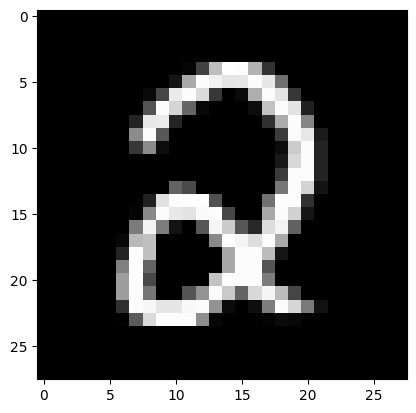

In [5]:
import matplotlib.cm as cm
# データセットの確認
# サンプル画像を表示
data_iter = iter(train_loader)
imgs, labels = data_iter._next_data()
print(imgs.size())
plt.imshow(imgs[0].permute(1,2,0),cmap=cm.gray);

In [6]:
# 入力する画像のテンソルサイズ
data_iter = iter(train_loader)
imgs, labels = data_iter._next_data()
c, h, w = imgs[0].shape
print("色の種類：", c)
print("画像の高さ：", h)
print("画像の幅　：", w)

色の種類： 1
画像の高さ： 28
画像の幅　： 28


In [7]:
# 分類するクラス数の設定
number_of_classes = 10

In [8]:
# ネットワークの定義
# 2層(1*28*28:1024 - ReLU - 1024:512 - ReLU - 512:10)
class My_MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifer = nn.Sequential(
            nn.Linear(c * h * w, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, number_of_classes)
        )
    
    def forward(self,x):
        return self.classifer(x)
    

In [9]:
model = My_MLP()
model.to(device)

My_MLP(
  (classifer): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [10]:
# 損失関数の設定（多クラス分類なので交差エントロピー誤差関数を使用）
criterion = nn.CrossEntropyLoss()

# 最適化関数の設定（モーメンタムSGDを使用）
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [11]:
# Training：モデル学習
def model_training():
    model.train()
    train_loss = 0
    train_acc = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1,28*28)
        images = images.to(device)
        labels = labels.to(device)
      
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        train_loss += loss.item()
        pred = torch.argmax(outputs, dim=1)
        train_acc += (pred == labels).sum().item()

        loss.backward()
        optimizer.step()
        
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    return avg_train_loss, avg_train_acc

In [12]:
# Validation：モデルのパラメータ評価
def model_val():
    model.eval()
    val_loss = 0
    val_acc = 0
    
    with torch.no_grad():
      for images, labels in val_loader:
          images = images.view(-1,28*28)
          images = images.to(device)
          labels = labels.to(device)

          outputs = model(images)
          loss = criterion(outputs, labels)
          
          val_loss += loss.item()
          pred = torch.argmax(outputs, dim=1)
          val_acc += (pred == labels).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_acc = val_acc / len(val_loader.dataset)

    return avg_val_loss, avg_val_acc

In [13]:
%%time
#処理時間計測

num_epochs = 10
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

for epoch in range(num_epochs):
    avg_train_loss = 0
    avg_train_acc = 0
    avg_val_loss = 0
    avg_val_acc = 0

    # モデル学習結果を受け取る
    avg_train_loss, avg_train_acc = model_training()

    # モデルのパラメータ評価結果を受け取る
    avg_val_loss, avg_val_acc = model_val()
        
    print ('Epoch [{}/{}], Loss: {loss:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, loss=avg_train_loss, val_loss=avg_val_loss, val_acc=avg_val_acc))
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)

Epoch [1/10], Loss: 0.0032, val_loss: 0.0015, val_acc: 0.9694
Epoch [2/10], Loss: 0.0012, val_loss: 0.0011, val_acc: 0.9790
Epoch [3/10], Loss: 0.0008, val_loss: 0.0014, val_acc: 0.9733
Epoch [4/10], Loss: 0.0006, val_loss: 0.0010, val_acc: 0.9821
Epoch [5/10], Loss: 0.0005, val_loss: 0.0012, val_acc: 0.9798
Epoch [6/10], Loss: 0.0004, val_loss: 0.0011, val_acc: 0.9808
Epoch [7/10], Loss: 0.0004, val_loss: 0.0012, val_acc: 0.9810
Epoch [8/10], Loss: 0.0003, val_loss: 0.0014, val_acc: 0.9797
Epoch [9/10], Loss: 0.0003, val_loss: 0.0014, val_acc: 0.9806
Epoch [10/10], Loss: 0.0002, val_loss: 0.0011, val_acc: 0.9833
CPU times: user 42.2 s, sys: 6.62 s, total: 48.8 s
Wall time: 57.6 s


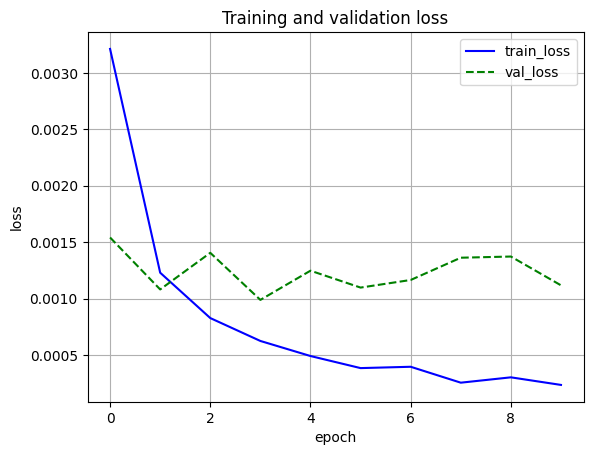

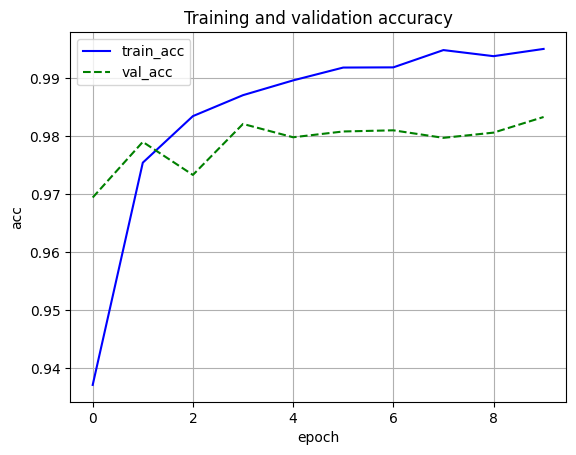

In [14]:
plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()